In [8]:
import praw
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

sns.set_palette("deep")
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['grid.color'] = '0.8'
mpl.rcParams['figure.figsize'] = '8, 8'
plt.rcParams["font.size"] = 18
plt.rcParams['font.family'] = 'Fira Mono'
plt.rcParams["axes.linewidth"]  = 2

from secret import CLIENT_ID, CLIENT_SECRET, USER_AGENT, USERNAME, PASSWORD

# https://praw.readthedocs.io/en/stable/getting_started/quick_start.html

# Create authorized reddit instance
reddit = praw.Reddit(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    user_agent=USER_AGENT,
    username=USERNAME,
    password=PASSWORD,
)

# Obtain specific submission
submission = reddit.submission(id='5y9qif')

# Loading all comments by making multiple api calls
# to replace all "load more comments" instances (may take a long time)
submission.comment_sort = "old"
submission.comments.replace_more(limit=None) 
all_comments = submission.comments.list()

In [27]:
# Create two Unix timestamps (number of seconds since 1 Jan 1970)
# Only comments between these two timestamps will be considered
time_start = dt.datetime(2017,3,8,19,0,0,
                              tzinfo=dt.timezone.utc).timestamp()
time_end = dt.datetime(2017,3,8,22,59,0,
                              tzinfo=dt.timezone.utc).timestamp()

comments  = [comment for comment in all_comments 
                        if comment.created_utc >= time_start
                          and comment.created_utc <= time_end]

comments_timestamps = [comment.created_utc for comment in comments]

In [28]:
df = pd.DataFrame({"datetime": pd.to_datetime(comments_timestamps, unit='s')})

In [29]:
min_bin = int(df['datetime'].min().floor('min').timestamp())
max_bin = int(df['datetime'].max().ceil('min').timestamp())

In [44]:
bin_range = list(range(min_bin, max_bin, 60))
x_ticks = list(range(min_bin, max_bin, 900))
minor_locator = AutoMinorLocator(15)

In [225]:
game_start = dt.datetime(2017,3,8,19,47,0, tzinfo=dt.timezone.utc).timestamp()
game_break_start = dt.datetime(2017,3,8,20,36,0, tzinfo=dt.timezone.utc).timestamp()
game_break_end = dt.datetime(2017,3,8,20,52,0, tzinfo=dt.timezone.utc).timestamp()
game_end = dt.datetime(2017,3,8,21,45,0, tzinfo=dt.timezone.utc).timestamp()

goals_barca = [dt.datetime(2017,3,8,19,50,0, tzinfo=dt.timezone.utc).timestamp(),
                    dt.datetime(2017,3,8,20,27,0, tzinfo=dt.timezone.utc).timestamp(),
                    dt.datetime(2017,3,8,20,57,0, tzinfo=dt.timezone.utc).timestamp(),
                    dt.datetime(2017,3,8,21,35,0, tzinfo=dt.timezone.utc).timestamp(),
                    dt.datetime(2017,3,8,21,38,0, tzinfo=dt.timezone.utc).timestamp(),
                    dt.datetime(2017,3,8,21,43,0, tzinfo=dt.timezone.utc).timestamp()]
                    
goal_paris = dt.datetime(2017,3,8,21,9,0, tzinfo=dt.timezone.utc).timestamp()

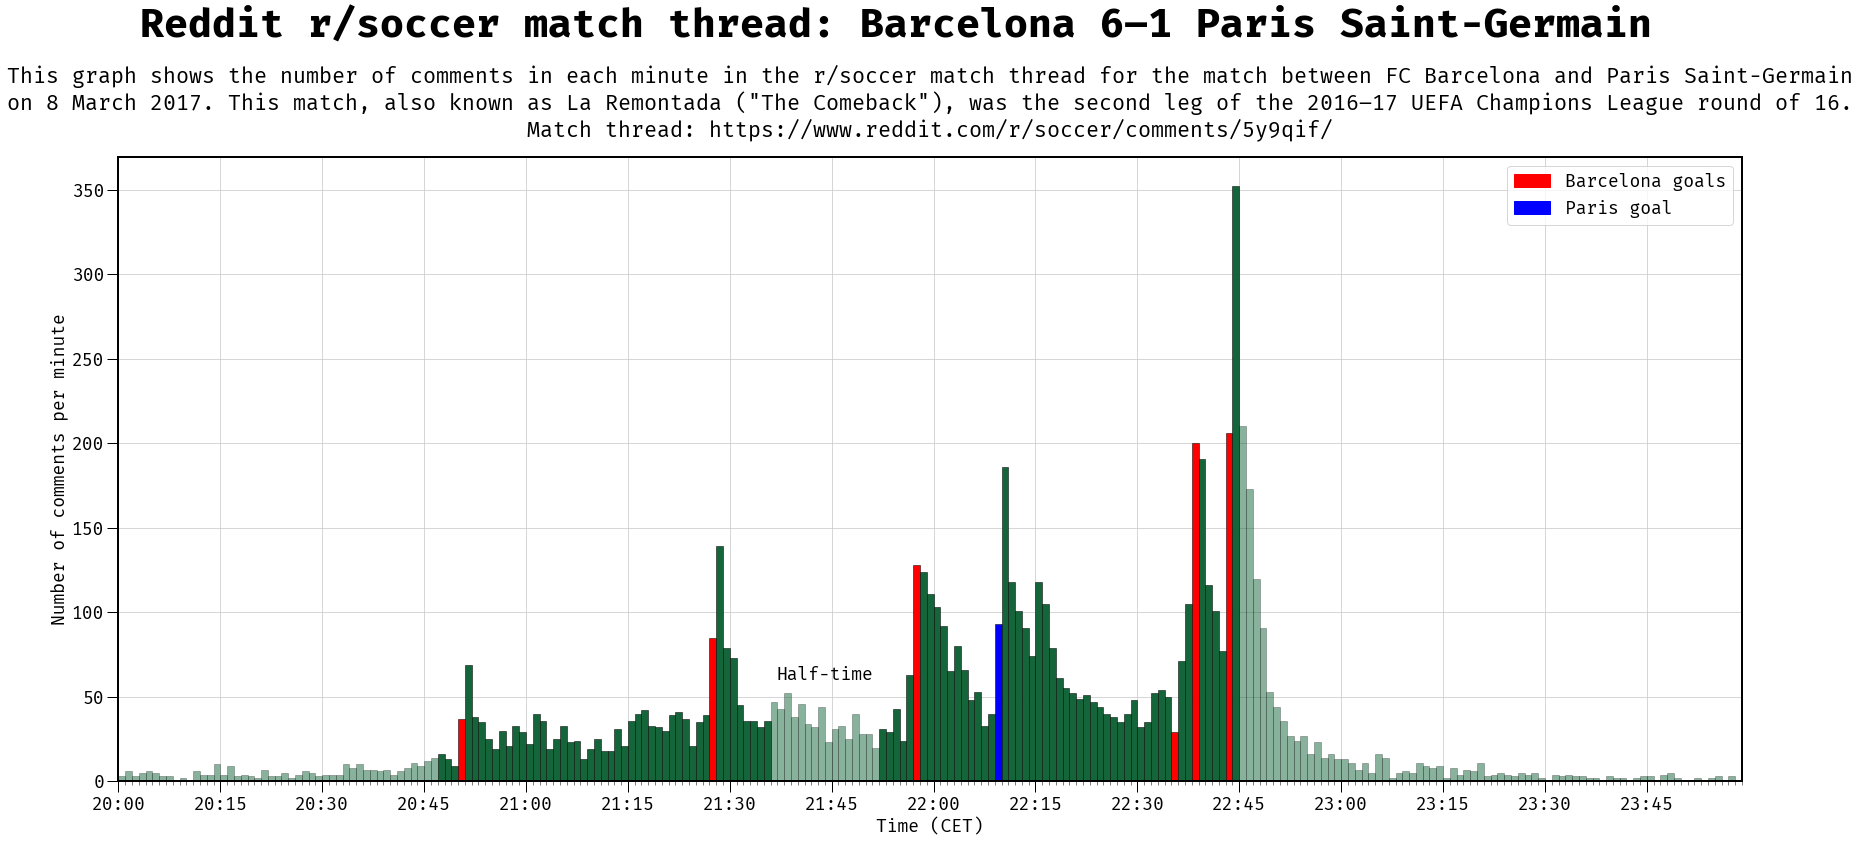

In [227]:
# Make histogram
fig, ax = plt.subplots(figsize=(24,12))
ax = (df["datetime"].view(int) / 10**9).hist(bins=bin_range, edgecolor='black', linewidth=0.5, color='#14663a', ax=ax)

# Color bins with different colors depending on the action
for patch in ax.patches:
    if (patch.xy[0] < game_start) or (patch.xy[0] >= game_end) or \
       (patch.xy[0] >= game_break_start and patch.xy[0] < game_break_end):
        patch.set_alpha(0.5)
    if patch.xy[0] in goals_barca:
        patch.set_facecolor('r')
    if patch.xy[0] == goal_paris:
        patch.set_facecolor('b')

# Configure ticks
ax.set_xticks(x_ticks)
ax.tick_params('both', length=11, width=1, which='major')
ax.tick_params('both', length=4, width=0.5, which='minor')
ax.xaxis.set_minor_locator(minor_locator)
ax.set_xlim(min_bin, max_bin)

#ax.axvline(x=game_start, c='gray')

# Configure axis labels
labels = pd.to_datetime(ax.get_xticks().tolist(), unit='s').tz_localize('UTC').tz_convert('Europe/Berlin').strftime("%H:%M")
ax.set_xticklabels(labels)
ax.set_xlabel('Time (CET)')
ax.set_ylabel('Number of comments per minute')

# Create legend
red_patch = Patch(color='red', label='Barcelona goals')
blue_patch = Patch(color='blue', label='Paris goal')
handles = [red_patch, blue_patch]
ax.legend(handles=handles, loc='upper right')

# Create text and title
ax.text(game_break_start+50, 60, 'Half-time', fontsize=18)

fig.suptitle('Reddit r/soccer match thread: Barcelona 6–1 Paris Saint-Germain', fontsize=40, fontweight='bold')
title = ax.set_title('This graph shows the number of comments in each minute in the r/soccer match thread for the match between FC Barcelona and Paris Saint-Germain\non 8 March 2017. This match, also known as La Remontada ("The Comeback"), was the second leg of the 2016–17 UEFA Champions League round of 16.\nMatch thread: https://www.reddit.com/r/soccer/comments/5y9qif/', loc='center', pad=20)

# Draw plot
plt.tight_layout(pad=1.0)
fig.savefig('myplot.png')
plt.show()